In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, sosfilt
from scipy.signal import hilbert
import numpy as np
from sklearn.cluster import KMeans
from scipy.signal import savgol_filter

In [55]:
ruth_achilles_cuff_file_names = [
    "logs/trial_1_7_16/cuff_data_trial_1_run_1_ruth.txt", 
    "logs/trial_1_7_16/cuff_data_trial_1_run_3_ruth.txt", 
    "logs/trial_1_7_16/cuff_data_trial_1_run_4_ruth.txt",  
    "logs/trial_1_7_16/cuff_data_trial_1_run_5_ruth.txt"
]
ruth_achilles_hammer_file_names = [
    "logs/trial_1_7_16/hammer_data_trial_1_run_1_ruth.txt", 
    "logs/trial_1_7_16/hammer_data_trial_1_run_3_ruth.txt", 
    "logs/trial_1_7_16/hammer_data_trial_1_run_4_ruth.txt",  
    "logs/trial_1_7_16/hammer_data_trial_1_run_5_ruth.txt"    
]

chosen_folder_cuff = ruth_achilles_cuff_file_names
chosen_folder_hammer = ruth_achilles_hammer_file_names

cuff_dfs = []
hammer_dfs = []
for file_name in chosen_folder_cuff:
    cuff_dfs.append(pd.read_csv(file_name, skiprows=1, header = None).to_numpy())
for file_name in chosen_folder_hammer:
    hammer_dfs.append(pd.read_csv(file_name, skiprows=1, header = None).to_numpy())

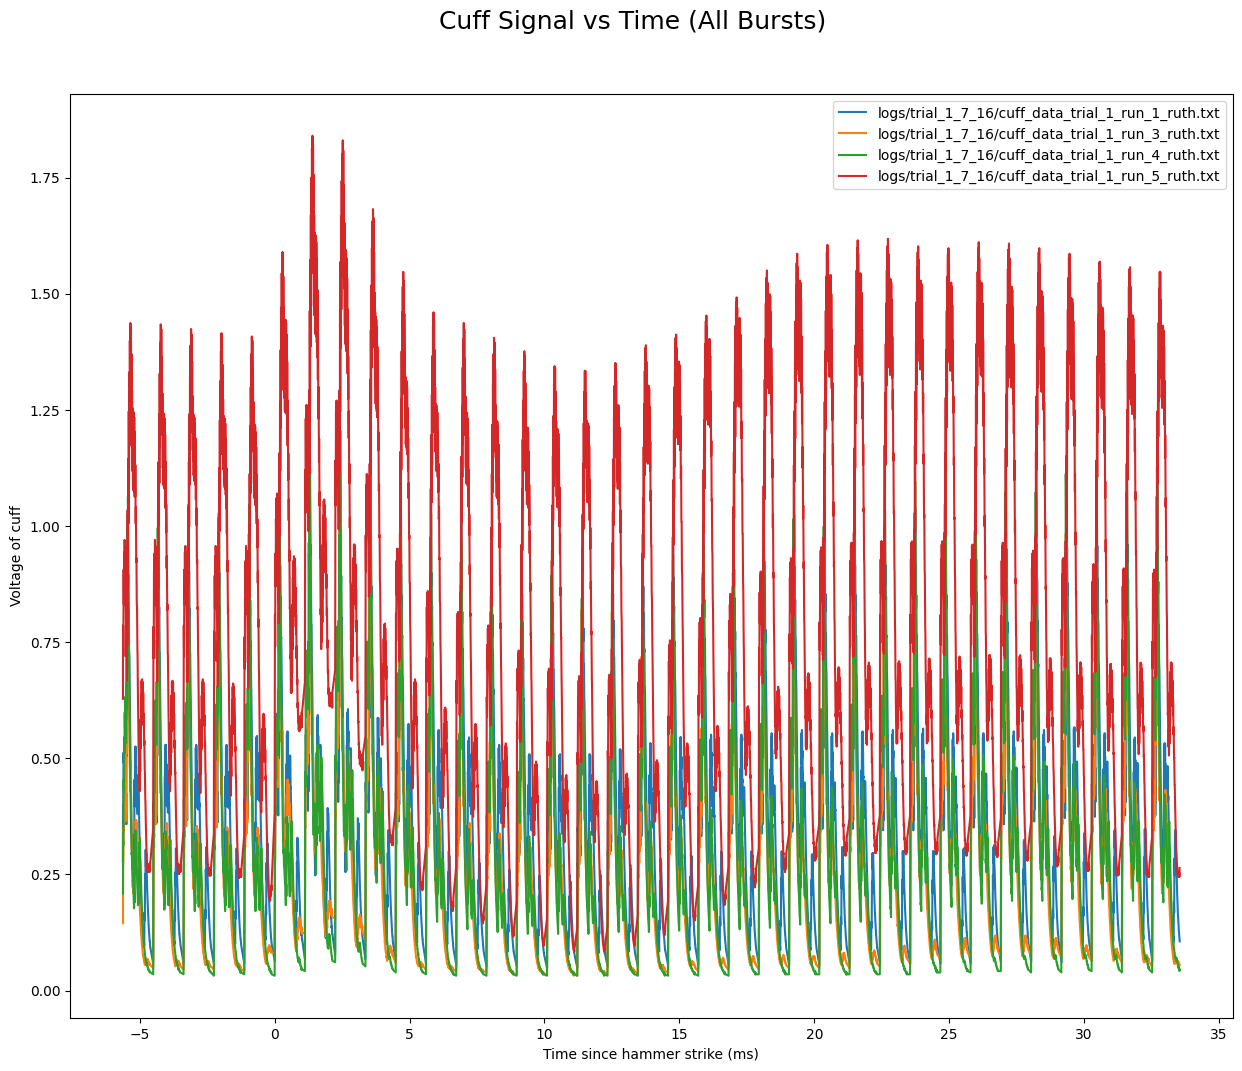

In [64]:
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Cuff Signal vs Time (All Bursts)", fontsize=18, y=0.95)

# loop through the length of tickers and keep track of index
n = 0
overlay = True
ax_subp = None
for n in range:
    # add a new subplot iteratively
    n+=1
    if (not overlay): ax_subp = plt.subplot(3, 2, n)
    elif (ax_subp is None): ax_subp = plt.subplot(1, 1, 1)

    # filter df and plot ticker on the new subplot axis
    ax_subp.plot(df[:,0], df[:,1])

    # chart formatting
    if (not overlay): ax_subp.set_title("Data from " + str(chosen_folder[n-1]))
    ax_subp.set_xlabel("Time since hammer strike (ms)")
    ax_subp.set_ylabel("Voltage of cuff")
    ax_subp.set_co

if (overlay): plt.legend(chosen_folder)
plt.show()

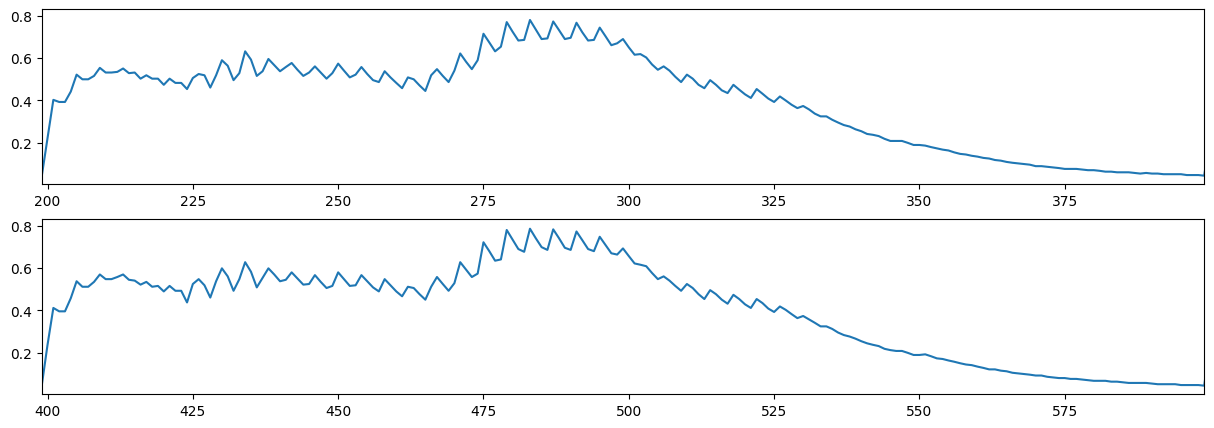

In [66]:
plt.figure(figsize=(15,5))
plt.subplot(2,1,1)
plt.plot(aa1[:,1])
plt.xlim((199,399))
plt.subplot(2,1,2)
plt.plot(aa1[:,1])
plt.xlim((399,599))

plt.show()

In [67]:
aaa1=aa1[199:6799,1]
aaa_chuped1=aaa1.reshape(-1,200)
aaaa1 = np.vstack(aaa_chuped1)

In [68]:
np.shape(aaaa1)

(33, 200)

In [69]:
T= aa1[199:6800:200,0]
t= aa1[999:1199,0]

In [70]:
aaaa1 = aaaa1.astype(float)

Text(0, 0.5, 'starting time of a fram (ms)')

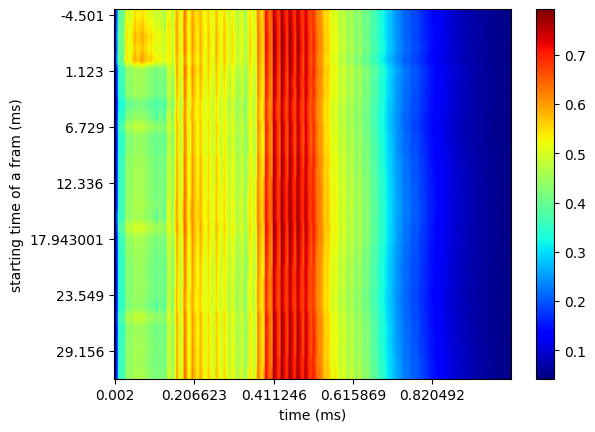

In [71]:
plt.imshow(aaaa1, aspect='auto', cmap='jet')
y_ticks = np.arange(0,35,5)
x_ticks = np.arange(0,200,40)

plt.xticks(ticks=x_ticks, labels=t[np.arange(0,200,40)])
plt.yticks(ticks=y_ticks, labels=T[np.arange(0, 35, 5)])
plt.colorbar()

plt.xlabel('time (ms)')
plt.ylabel('starting time of a fram (ms)')

Text(0, 0.5, 'starting time of a fram (ms)')

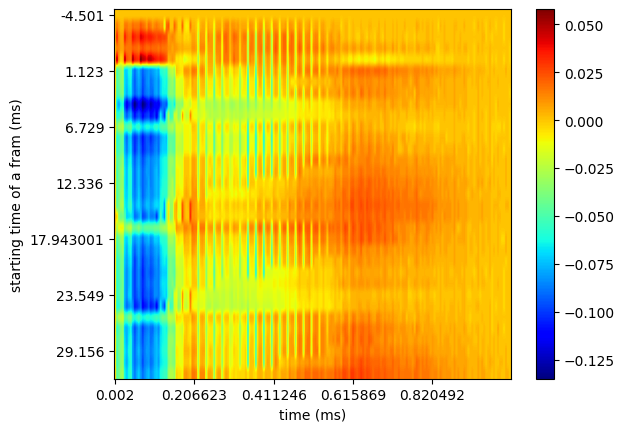

In [72]:
plt.imshow(aaaa1-aaaa1[0,:], aspect='auto', cmap='jet')
y_ticks = np.arange(0,35,5)
x_ticks = np.arange(0,200,40)

plt.xticks(ticks=x_ticks, labels=t[np.arange(0,200,40)])
plt.yticks(ticks=y_ticks, labels=T[np.arange(0, 35, 5)])
plt.colorbar()

plt.xlabel('time (ms)')
plt.ylabel('starting time of a fram (ms)')

Text(0, 0.5, 'starting time of a fram (ms)')

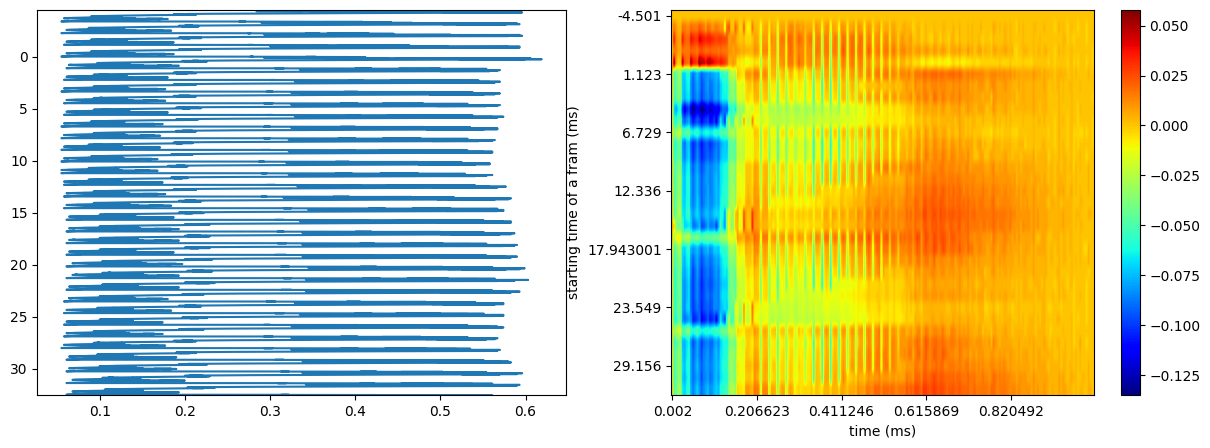

In [73]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)

plt.plot(bb1[:,1],bb1[:,0])
plt.ylim((max(T),min(T)))
plt.subplot(1,2,2)

plt.imshow(aaaa1-aaaa1[0,:], aspect='auto', cmap='jet')
y_ticks = np.arange(0,35,5)
x_ticks = np.arange(0,200,40)

plt.xticks(ticks=x_ticks, labels=t[np.arange(0,200,40)])
plt.yticks(ticks=y_ticks, labels=T[np.arange(0, 35, 5)])
plt.colorbar()

plt.xlabel('time (ms)')
plt.ylabel('starting time of a fram (ms)')

In [74]:
plt.figure(figsize=(15,5))
plt.subplot(2,1,1)

plt.plot(bb1[:,0],bb1[:,1])
plt.ylim((min(T),max(T)))
plt.subplot(2,1,2)

plt.imshow((aaaa1-aaaa1[0,:], aspect='auto', cmap='jet')
y_ticks = np.arange(0,35,5)
x_ticks = np.arange(0,200,40)

plt.xticks(ticks=x_ticks, labels=t[np.arange(0,200,40)])
plt.yticks(ticks=y_ticks, labels=T[np.arange(0, 35, 5)])
plt.colorbar()

plt.xlabel('time (ms)')
plt.ylabel('starting time of a fram (ms)')

SyntaxError: invalid syntax. Maybe you meant '==' or ':=' instead of '='? (2772712658.py, line 8)